In [3]:
def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            # print(i)
            # print(l[0:100])

            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
#             print(i)
#             print(l[0:100])
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [6]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

time-reasoning -> 28.775954581718683
two-supporting-facts -> 7.996099424726351
three-arg-relations -> 67.59088676155083
single-supporting-fact -> 35.772348606559156
conjunction -> 27.5323685213614
three-supporting-facts -> 3.8784005754064124
two-arg-relations -> 52.1950521950522
compound-coreference -> 8.451739352293382
simple-negation -> 20.300111551383658
agents-motivations -> 24.04645354645355
lists-sets -> 78.49535988565779
basic-deduction -> 9.035845915712434
basic-coreference -> 4.867682419284248


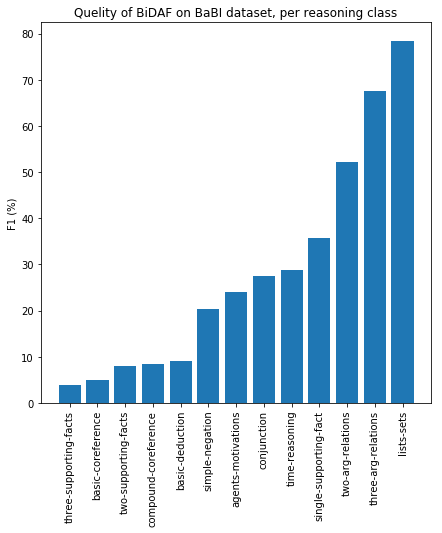

In [7]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set(bibi_reasoning_types)
for c in unique_types111:
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))
    scores.append(100.0 * sum(similarity) / len(predictions_a))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]


import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on BaBI dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [6]:
mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

In [6]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=len(unique_reasoning_types), random_state=2).fit(mat_ad)
# db = DBSCAN(eps=0.3, min_samples=10).fit(mat_ad)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
labelsss = db.labels_

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

matt1 = confusion_matrix(bibi_reasoning_type_indices, labelsss)
max_values = np.max(matt1, axis=1)
max_indices = np.argmax(matt1, axis=1)
    

max_indices = list(enumerate(max_indices))
max_indices.sort(key=lambda x: x[1])
new_ordering = [x[0] for x in max_indices]

matt = matt1[new_ordering, :]

matt1, max_values, max_indices, new_ordering, matt1[new_ordering, :]

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(array([[  0,   0,   0,   0,  95,   0, 135,   1, 323,   0,  50,   0,   0],
        [  0,   0,  32, 189,  76,   0,   0,   0,   0,   0,   0,  66,  25],
        [  0,   0,   0,  10,   0,   0,   8,   7,   2,   0,  94,   0,   9],
        [  0,   0,  71, 118, 301,   0,   0,   0,   0,   0,   0, 243,  19],
        [  0,   0, 119,  87,   0,   0,   0, 260,   0,   0,   0,   0, 134],
        [  0,   0, 162,  20,   0,   0,   0, 265,   0,   0,   0,   0, 153],
        [  0, 321,   0,   2,  11,   0,   0,   0,   0,   0,   0,   1,  89],
        [  0,   0, 105,  54,   0,   0,   0, 311,   0,   0,   0,   0, 130],
        [  0,   0,   0,   0,   0, 186,   0,   0,   0,   0,   0,   0,   0],
        [713,   0,   0,   0,   0,   0,   0,   0,   0, 286,   0,   0,   0],
        [  0,   0,   0, 115,   3,   0,   0,   0,   0,   0, 169,   1,   1],
        [  0,   0,   0,   1,   0,   0, 232,   0,   0,   0,  99,   0,   0],
        [  0,   0, 176,  15,   0,   0,   0, 245,   0,   0,   0,   0, 164]]),
 array([323, 189,  94, 

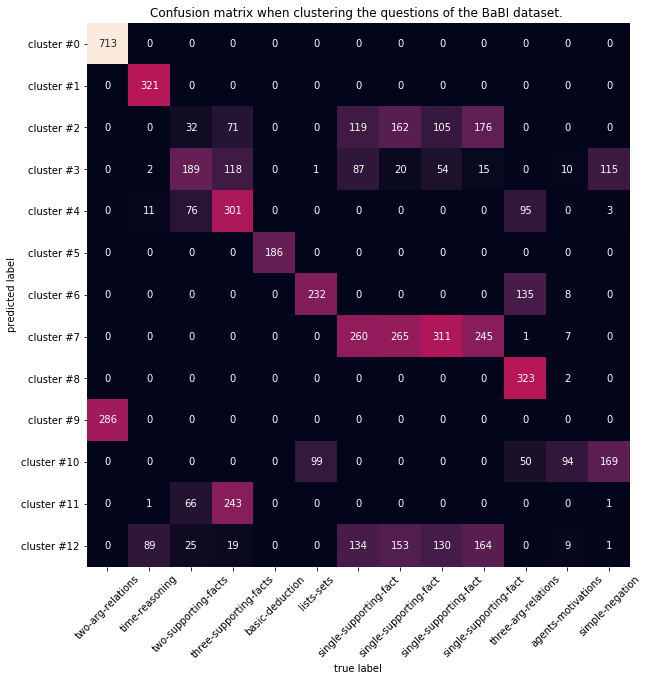

13
ars: 0.36046123193936175


In [8]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(new_label_ordering, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()
print(len(unique_reasoning_types))

ars = metrics.adjusted_rand_score(labelsss, bibi_reasoning_type_indices)
print("ars: " + str(ars))

In [9]:
# couts of the types  
values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

values, counts,dict(zip(counts, values)), new_label_ordering

(array(['agents-motivations', 'basic-coreference', 'basic-deduction',
        'compound-coreference', 'conjunction', 'lists-sets',
        'simple-negation', 'single-supporting-fact', 'three-arg-relations',
        'three-supporting-facts', 'time-reasoning', 'two-arg-relations',
        'two-supporting-facts'], dtype='<U22'),
 array([130, 600, 186, 600, 600, 332, 289, 600, 604, 752, 424, 999, 388]),
 {130: 'agents-motivations',
  600: 'single-supporting-fact',
  186: 'basic-deduction',
  332: 'lists-sets',
  289: 'simple-negation',
  604: 'three-arg-relations',
  752: 'three-supporting-facts',
  424: 'time-reasoning',
  999: 'two-arg-relations',
  388: 'two-supporting-facts'},
 ['two-arg-relations',
  'time-reasoning',
  'two-supporting-facts',
  'three-supporting-facts',
  'basic-deduction',
  'lists-sets',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'three-arg-relations',
  'agents-motivations',
  'simple-negation'

three-arg-relations -> 67.59088676155083
two-supporting-facts -> 7.996099424726351
agents-motivations -> 24.04645354645355
three-supporting-facts -> 3.8784005754064124
single-supporting-fact -> 35.772348606559156
conjunction -> 27.5323685213614
time-reasoning -> 28.775954581718683
basic-coreference -> 4.867682419284248
basic-deduction -> 9.035845915712434
two-arg-relations -> 52.1950521950522
simple-negation -> 20.300111551383658
lists-sets -> 78.49535988565779
compound-coreference -> 8.451739352293382


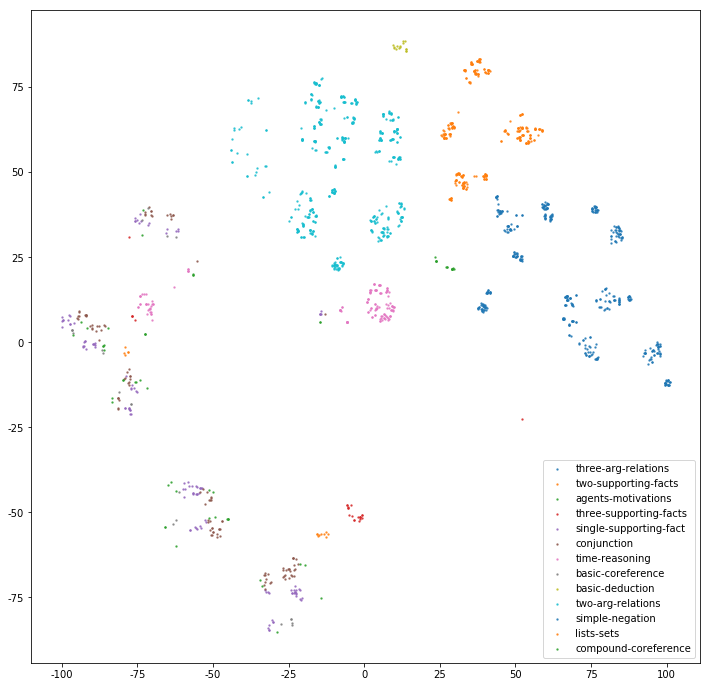

In [10]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=100)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

# find the quality per reasoning type
for c in set(bibi_reasoning_types):
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]
# print("Squad -> ", str(100.0 * sum(similarity) / len(pred_ans)))


mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

X_embedded = TSNE(n_components=2,init="pca").fit_transform(mat_concat)
fig, ax = plt.subplots(figsize=(12, 12))
for iter, c in enumerate(unique_reasoning_types):
    X_selected = np.asarray([X_embedded[i, :] for i, r in enumerate(reasoning_types) if r == c and f1_score(pred_concat[i], labels_concat[i]) > 0.6])
    plt.scatter(X_selected[:, 0], X_selected[:, 1], alpha=0.7, s=2, label=c) # color=color_map[iter],

ax.legend()
plt.show()

In [11]:
# clustering points into two groups 

(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)



# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                question_paragraph_id_map[key] = qa['id']

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]
bibi_reasoning_types

['agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-motivations',
 'agents-mo

In [40]:
import numpy 

unique_reasoning_types = list(set(bibi_reasoning_types))

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 
count_table = np.empty(shape=(ss, ss), dtype=object) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
        
        count1 = 0
        count2 = 0
            
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(bibi_reasoning_types): 
            if x == type1 or x == type2:
                points.append(mat_ad[i])
                labels.append(x)
            if x == type1:
                count1 = count1 + 1

            if x == type2:
                count2 = count2 + 1

        from sklearn.cluster import KMeans
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        countstr = str(f"{len(labels)}/{count1}/{count2}")
        print(countstr)
        count_table[ind1][ind2] = countstr
        count_table[ind2][ind1] = count_table[ind1][ind2] 
accuracy_table

type1:  compound-coreference  type2:  conjunction
same_label_same_cluster:  0.25293438976925214 363922
same_label_diff_cluster:  0.24664859605226577 354878
diff_label_same_cluster:  0.2532666110647762 364400
diff_label_diff_cluster:  0.24715040311370587 355600
---------
1200/600/600
type1:  compound-coreference  type2:  basic-deduction
same_label_same_cluster:  0.6382554577721593 393810
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.3617445422278407 223200
---------
786/600/186
type1:  compound-coreference  type2:  three-arg-relations
same_label_same_cluster:  0.49875725967473344 722406
same_label_diff_cluster:  0.0008326360179286004 1206
diff_label_same_cluster:  0.0008284935501777119 1200
diff_label_diff_cluster:  0.49958161075716023 723600
---------
1204/600/604
type1:  compound-coreference  type2:  three-supporting-facts
same_label_same_cluster:  0.43395972301910923 792650
same_label_diff_cluster:  0.07199466535855535 131502
diff_label_s

same_label_same_cluster:  0.5754179116530728 213762
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.42458208834692723 157728
---------
610/186/424
type1:  basic-deduction  type2:  basic-coreference
same_label_same_cluster:  0.6382554577721593 393810
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.3617445422278407 223200
---------
786/186/600
type1:  three-arg-relations  type2:  three-supporting-facts
same_label_same_cluster:  0.5055916576864884 928964
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4944083423135116 908416
---------
1356/604/752
type1:  three-arg-relations  type2:  single-supporting-fact
same_label_same_cluster:  0.49875725967473344 722406
same_label_diff_cluster:  0.0008326360179286004 1206
diff_label_same_cluster:  0.0008284935501777119 1200
diff_label_diff_cluster:  0.49958161075716023 723600
---------
1204/604/600
type1:  three-arg-rela

same_label_same_cluster:  0.35030340211257766 230686
same_label_diff_cluster:  0.15006408192768156 98822
diff_label_same_cluster:  0.14995778489124295 98752
diff_label_diff_cluster:  0.34967473106849783 230272
---------
812/388/424
type1:  two-supporting-facts  type2:  basic-coreference
same_label_same_cluster:  0.42393627276046086 413404
same_label_diff_cluster:  0.0986016596318948 96152
diff_label_same_cluster:  0.09947946790052054 97008
diff_label_diff_cluster:  0.3779825997071238 368592
---------
988/388/600
type1:  simple-negation  type2:  two-arg-relations
same_label_same_cluster:  0.6513160752291187 1079658
same_label_diff_cluster:  0.00034747860834817356 576
diff_label_same_cluster:  0.001205316422707727 1998
diff_label_diff_cluster:  0.3471311297398254 575424
---------
1288/289/999
type1:  simple-negation  type2:  agents-motivations
same_label_same_cluster:  0.5709766931975198 100002
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.42

array([[0.        , 0.50008479, 1.        , 0.99833887, 0.8616508 ,
        0.51034751, 0.8682057 , 0.98657769, 1.        , 0.96761937,
        1.        , 0.8346946 , 0.51520156],
       [0.50008479, 0.        , 1.        , 0.99833887, 0.8616508 ,
        0.50492633, 0.86473549, 0.97773082, 1.        , 0.96761937,
        1.        , 0.84112483, 0.50892966],
       [1.        , 1.        , 0.        , 0.64221976, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.99833887, 0.99833887, 0.64221976, 0.        , 1.        ,
        0.99833887, 1.        , 0.66463124, 0.99875234, 0.6131608 ,
        0.68508844, 0.70083997, 0.99833887],
       [0.8616508 , 0.8616508 , 1.        , 1.        , 0.        ,
        0.8603927 , 0.61689386, 0.82152147, 0.90242963, 0.78656237,
        0.84759432, 0.81794326, 0.8603927 ],
       [0.51034751, 0.50492633, 1.        , 0.99833887, 0.8603927 ,
        0.        , 0.75073

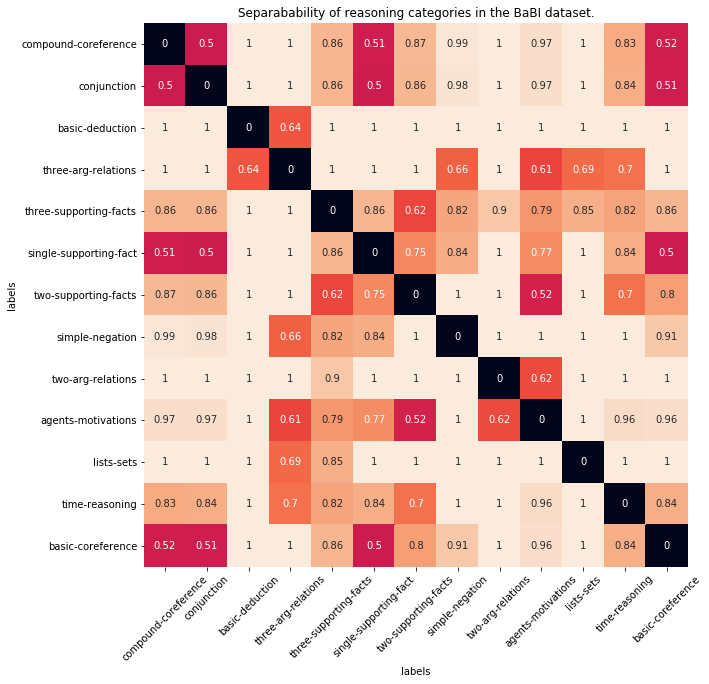

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types, rotation=45)
sss.set_yticklabels(unique_reasoning_types, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the BaBI dataset.')
plt.show()

In [45]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in accuracy_table]))

0.0	0.500084792882958	1.0	0.9983388704318937	0.8616508043570619	0.5103475118154017	0.8682057024722198	0.9865776913021007	1.0	0.9676193697502677	1.0	0.8346946022727273	0.515201556852933
0.500084792882958	0.0	1.0	0.9983388704318937	0.8616508043570619	0.5049263274951349	0.86473548847569	0.9777308241875171	1.0	0.9676193697502677	1.0	0.8411248319892473	0.5089296636085627
1.0	1.0	0.0	0.6422197622370891	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0
0.9983388704318937	0.9983388704318937	0.6422197622370891	0.0	1.0	0.9983388704318937	1.0	0.66463123747734	0.9987523393636931	0.6131608001159804	0.6850884409707939	0.7008399668105131	0.9983388704318937
0.8616508043570619	0.8616508043570619	1.0	1.0	0.0	0.8603926961838481	0.6168938588789797	0.8215214660459618	0.9024296320469936	0.7865623737198246	0.8475943208185545	0.8179432624113475	0.8603926961838481
0.5103475118154017	0.5049263274951349	1.0	0.9983388704318937	0.8603926961838481	0.0	0.750735266972669	0.839737938163135	1.0	0.765229156096736	1.0	0.84112483198924

In [44]:
count_table[count_table == None] = ""
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in count_table]))

	1200/600/600	786/600/186	1204/600/604	1352/600/752	1200/600/600	988/600/388	889/600/289	1599/600/999	730/600/130	932/600/332	1024/600/424	1200/600/600
1200/600/600		786/600/186	1204/600/604	1352/600/752	1200/600/600	988/600/388	889/600/289	1599/600/999	730/600/130	932/600/332	1024/600/424	1200/600/600
786/600/186	786/600/186		790/186/604	938/186/752	786/186/600	574/186/388	475/186/289	1185/186/999	316/186/130	518/186/332	610/186/424	786/186/600
1204/600/604	1204/600/604	790/186/604		1356/604/752	1204/604/600	992/604/388	893/604/289	1603/604/999	734/604/130	936/604/332	1028/604/424	1204/604/600
1352/600/752	1352/600/752	938/186/752	1356/604/752		1352/752/600	1140/752/388	1041/752/289	1751/752/999	882/752/130	1084/752/332	1176/752/424	1352/752/600
1200/600/600	1200/600/600	786/186/600	1204/604/600	1352/752/600		988/600/388	889/600/289	1599/600/999	730/600/130	932/600/332	1024/600/424	1200/600/600
988/600/388	988/600/388	574/186/388	992/604/388	1140/752/388	988/600/388		677/388/289	1387/

In [42]:
unique_reasoning_types

['compound-coreference',
 'conjunction',
 'basic-deduction',
 'three-arg-relations',
 'three-supporting-facts',
 'single-supporting-fact',
 'two-supporting-facts',
 'simple-negation',
 'two-arg-relations',
 'agents-motivations',
 'lists-sets',
 'time-reasoning',
 'basic-coreference']

In [8]:
from sklearn.cluster import SpectralClustering

# Cluster
cluster_size = 3
sc = SpectralClustering(cluster_size, affinity='precomputed')
sc.fit(accuracy_table > 0.9)
# cluster_labels = sc.labels_
# cluster_labels

# db = KMeans(n_clusters=cluster_size, random_state=2).fit(accuracy_table > 0.8)
# db = DBSCAN(eps=0.3, min_samples=10, affinity='precomputed').fit(accuracy_table > 0.9)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

NameError: name 'accuracy_table' is not defined

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

unique_reasoning_types_new_ordering = []
new_to_old_type_map = {}
for cluster_id in range(cluster_size): 
    for label_id in range(len(cluster_labels)): 
        if cluster_labels[label_id] == cluster_id: 
            print(f"Type {unique_reasoning_types[label_id]} in cluster {cluster_id} ")
            new_id = len(unique_reasoning_types_new_ordering)
            new_to_old_type_map[new_id] = label_id
            unique_reasoning_types_new_ordering.append(unique_reasoning_types[label_id])
            
unique_reasoning_types_new_ordering, new_to_old_type_map

accuracy_table_new = np.zeros(shape=(ss, ss)) 

for new_id1 in range(len(unique_reasoning_types_new_ordering)): 
    for new_id2 in range(len(unique_reasoning_types_new_ordering)):
        id1 = new_to_old_type_map[new_id1]
        id2 = new_to_old_type_map[new_id2]
        accuracy_table_new[new_id1][new_id2] = accuracy_table[id1][id2]
    
plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table_new, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True)

sss.set_xticklabels(unique_reasoning_types_new_ordering, rotation=90)
sss.set_yticklabels(unique_reasoning_types_new_ordering, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()

NameError: name 'cluster_labels' is not defined

array([[0.        , 0.80545077, 1.        , 1.        , 0.80098854,
        0.72545809, 0.67228074, 1.        , 0.61366863, 1.        ,
        0.62510531, 0.5285914 , 1.        ],
       [0.80545077, 0.        , 1.        , 0.97643071, 0.50312379,
        0.50784593, 0.50504432, 0.99668601, 0.78337699, 1.        ,
        0.77103167, 0.9574487 , 1.        ],
       [1.        , 1.        , 0.        , 0.99762596, 1.        ,
        1.        , 1.        , 0.99765311, 0.84439423, 1.        ,
        1.        , 0.5859797 , 1.        ],
       [1.        , 0.97643071, 0.99762596, 0.        , 0.9612939 ,
        0.85222407, 0.76254505, 0.59954069, 0.74842987, 1.        ,
        1.        , 1.        , 1.        ],
       [0.80098854, 0.50312379, 1.        , 0.9612939 , 0.        ,
        0.50589387, 0.50297803, 0.99668601, 0.78337699, 1.        ,
        0.77878706, 0.9574487 , 1.        ],
       [0.72545809, 0.50784593, 1.        , 0.85222407, 0.50589387,
        0.        , 0.50838

[[0.         0.13414614 2.89063791 0.12553482 4.46059291 4.50969415
  0.09430194 4.43317558 6.28424819 4.33486686 5.77022867 4.72377553
  3.34810039]
 [0.13414614 0.         2.75649177 0.08070907 4.4172158  4.50969415
  0.04764855 4.29902944 6.15010205 4.20072072 5.63608253 4.58962939
  3.21395424]
 [2.89063791 2.75649177 0.         2.83720084 2.00168497 1.81869806
  2.80414033 1.54253766 3.39361027 3.13518866 2.87959076 1.83313762
  0.45746247]
 [0.12553482 0.08070907 2.83720084 0.         4.33650673 4.53403192
  0.04998066 4.37973851 6.23081112 4.28142979 5.7167916  4.67033846
  3.29466332]
 [4.46059291 4.4172158  2.00168497 4.33650673 0.         3.76933361
  4.38648739 2.13506399 3.98613661 3.727715   3.47211709 3.83482259
  2.45914744]
 [4.50969415 4.50969415 1.81869806 4.53403192 3.76933361 0.
  4.53403192 3.36123573 4.39530374 3.97487788 4.69828882 3.65183568
  2.27616053]
 [0.09430194 0.04764855 2.80414033 0.04998066 4.38648739 4.53403192
  0.         4.34667799 6.1977506  4.248

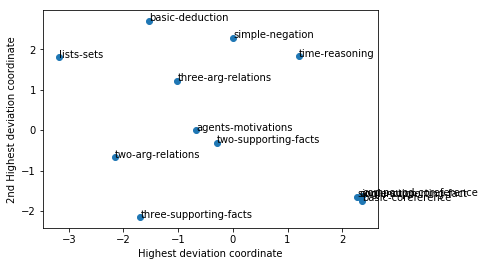

In [131]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

dissimalrity = accuracy_table_new

#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
distanceMatrix = distanceMatrix # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_reasoning_types_new_ordering):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

In [11]:
# binary classifier 
from sklearn.linear_model import LogisticRegression
import numpy 

unique_reasoning_types = list(set(bibi_reasoning_types))

# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 

for ind1, type1 in enumerate(unique_reasoning_types): 
    for ind2, type2 in enumerate(unique_reasoning_types):
        
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(bibi_reasoning_types): 
            if x == type1 or x == type2:
                points.append(mat_ad[i])
                labels.append(x)
        
#         from sklearn.cluster import KMeans
#         db = KMeans(n_clusters=2, random_state=2).fit(points)
#         cluster_labels = db.labels_
        clf = LogisticRegression()
#         print("points: ", len(points))
#         print("labels: ", len(labels))
        clf.fit(points, labels) 
#         print("labels: ", labels)
        cluster_labels = clf.predict(points)
#         print("cluster_labels: ", len(cluster_labels))
#         print(cluster_labels)
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] == labels[jj]: 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and labels[ii] != labels[jj]: 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
accuracy_table

type1:  three-supporting-facts  type2:  basic-deduction
same_label_same_cluster:  0.681713402798479 599162
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.31828659720152097 279744
---------
type1:  three-supporting-facts  type2:  single-supporting-fact
same_label_same_cluster:  0.5059543883776646 924152
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4940456116223354 902400
---------
type1:  three-supporting-facts  type2:  basic-coreference
same_label_same_cluster:  0.5059543883776646 924152
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4940456116223354 902400
---------
type1:  three-supporting-facts  type2:  two-supporting-facts
same_label_same_cluster:  0.5505814580349029 714908
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4494185419650971 583552
---------
type1:  three-supporting-facts  type2:  three-arg-

same_label_same_cluster:  0.5142961876832844 538752
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.48570381231671556 508800
---------
type1:  basic-coreference  type2:  two-arg-relations
same_label_same_cluster:  0.530839440482592 1356402
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.46916055951740804 1198800
---------
type1:  basic-coreference  type2:  lists-sets
same_label_same_cluster:  0.5408509010109578 469292
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4591490989890422 398400
---------
type1:  basic-coreference  type2:  compound-coreference
same_label_same_cluster:  0.49792048929663607 716408
same_label_diff_cluster:  0.001662496524881846 2392
diff_label_same_cluster:  0.0016680567139282735 2400
diff_label_diff_cluster:  0.4987489574645538 717600
---------
type1:  basic-coreference  type2:  simple-negation
same_label_same_cluster:  0.560696804

same_label_same_cluster:  0.5408509010109578 469292
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.4591490989890422 398400
---------
type1:  compound-coreference  type2:  simple-negation
same_label_same_cluster:  0.560696804791293 442632
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.43930319520870703 346800
---------
type1:  compound-coreference  type2:  agents-motivations
same_label_same_cluster:  0.7068605896611985 376170
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.29313941033880153 156000
---------
type1:  compound-coreference  type2:  conjunction
same_label_same_cluster:  0.49958298582151794 718800
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.5004170141784821 720000
---------
type1:  simple-negation  type2:  agents-motivations
same_label_same_cluster:  0.5709766931975198 100002
same_label_diff_clust

array([[0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99666945,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.     

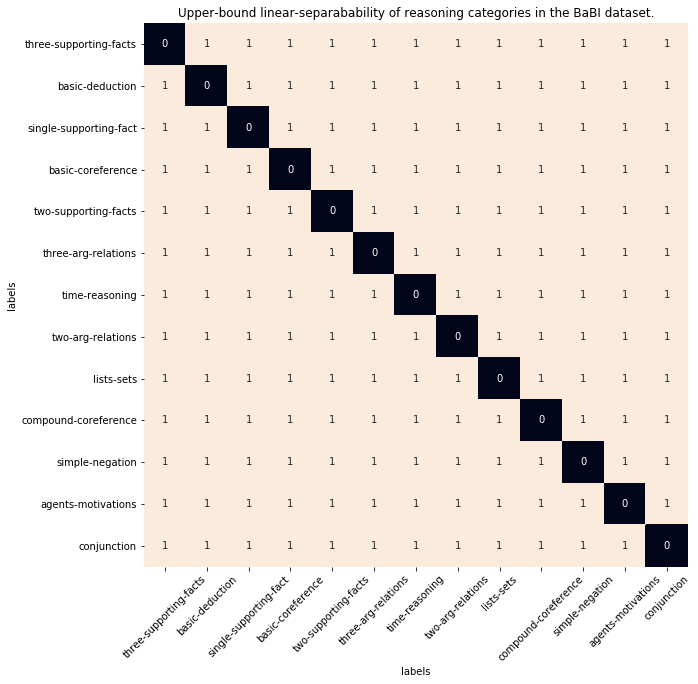

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_reasoning_types, rotation=45)
sss.set_yticklabels(unique_reasoning_types, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Upper-bound linear-separabability of reasoning categories in the BaBI dataset.')
plt.show()

In [ ]:
print(len(mat_ad))
print(len(bibi_reasoning_types))

In [88]:
from sklearn.neural_network import MLPClassifier

# training a single classifier on the data 
from sklearn.linear_model import LogisticRegression
import numpy 

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 

mlp = MLPClassifier(hidden_layer_sizes=(), alpha=10)
mlp.fit(mat_ad,bibi_reasoning_types)

MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [89]:
predictions = mlp.predict(mat_ad)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(bibi_reasoning_types,predictions))
print(classification_report(bibi_reasoning_types,predictions))

# bibi_reasoning_types

[[117   2   0   0   2   0   0   9   0   0   0   0   0]
 [  0 545   0  41   2   0   0  12   0   0   0   0   0]
 [  0   0 186   0   0   0   0   0   0   0   0   0   0]
 [  0  22   0 529  37   0   0  12   0   0   0   0   0]
 [  0   0   0   1 584   0   0  15   0   0   0   0   0]
 [  0   0   0   0   0 332   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 289   0   0   0   0   0   0]
 [  0   3   0   0  12   0   0 585   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 604   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 752   0   0   0]
 [  0   3   0   0   0   0   0   0   0   3 418   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 999   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0 387]]
                        precision    recall  f1-score   support

    agents-motivations       1.00      0.90      0.95       130
     basic-coreference       0.95      0.91      0.93       600
       basic-deduction       1.00      1.00      1.00       186
  compound-coreference     

In [8]:
# train a single classifier, which gets two input vectors and tell us whether the they share a class or not. 
import random 

# first, create the input data. 
assert len(mat_ad) == len(bibi_reasoning_types)

input_mat = []
output_vals = []

for i, x1 in enumerate(mat_ad): 
    if i % 500 == 0: 
        print(f"adding instances: {100.0 * i / len(mat_ad)}")
        
    if random.uniform(0, 1) < 0.99: # randomly skip half of the instances 
            continue 
        
    for j, x2 in enumerate(mat_ad): 
        if i == j: 
            continue 
        
        if bibi_reasoning_types[i] ==  bibi_reasoning_types[j]: 
            output_vals.append(1)
            input_mat.append(mat_ad[i] + mat_ad[j])
        else: 
            if random.uniform(0, 1) < 0.93: # randomly skip half of the instances 
                continue 
            output_vals.append(0)
            input_mat.append(mat_ad[i] + mat_ad[j])
            

adding instances: 0.0
adding instances: 7.687576875768758
adding instances: 15.375153751537516
adding instances: 23.062730627306273
adding instances: 30.75030750307503
adding instances: 38.43788437884379
adding instances: 46.125461254612546
adding instances: 53.8130381303813
adding instances: 61.50061500615006
adding instances: 69.18819188191883
adding instances: 76.87576875768758
adding instances: 84.56334563345634
adding instances: 92.25092250922509
adding instances: 99.93849938499385


In [9]:
# make sure the dataset selection is balanced 
sum(output_vals), len(output_vals)

(40255, 67150)

In [10]:
# train the classifier 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(input_mat, output_vals) 

sum(output_vals)

40255

In [13]:
ss = len(unique_types111)
separation_table = np.zeros(shape=(ss, ss)) 
unique_types111_list = list(unique_types111)
for ind1, type1 in enumerate(unique_types111_list): 
    for ind2, type2 in enumerate(unique_types111_list):
        
        # we want different types 
        if type1 == type2: #  or ind2 <= ind1  
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 

        y_true = []
        input_vecs = []
        for i, x in enumerate(bibi_reasoning_types): 
            for j, y in enumerate(bibi_reasoning_types): 
                if type1 == x and type2 == y: 
                    input_vecs.append(mat_ad[i] + mat_ad[j]) 
                    if x != y: 
                        y_true.append(1)
                    else: 
                        y_true.append(0)
                
        y_pred = list(clf.predict(input_vecs))
        
        assert(len(y_pred) == len(y_true))
#         print(y_pred)
#         print(y_true)
    
        from sklearn.metrics import f1_score
        separation_table[ind1][ind2] = f1_score(y_true, y_pred)
        print(separation_table[ind1][ind2])
    

type1:  time-reasoning  type2:  two-supporting-facts
0.1882038094503885
type1:  time-reasoning  type2:  three-arg-relations
0.9850610221280761
type1:  time-reasoning  type2:  single-supporting-fact
0.7476462986893114
type1:  time-reasoning  type2:  conjunction
0.39198520929791575
type1:  time-reasoning  type2:  three-supporting-facts
0.3520747139951779
type1:  time-reasoning  type2:  two-arg-relations
0.9960191658380669
type1:  time-reasoning  type2:  compound-coreference
0.7766025232572957
type1:  time-reasoning  type2:  simple-negation
0.6849961902922207
type1:  time-reasoning  type2:  agents-motivations
0.003513410724957893
type1:  time-reasoning  type2:  lists-sets
0.29980071260341806
type1:  time-reasoning  type2:  basic-deduction
0.0001267925293841687
type1:  time-reasoning  type2:  basic-coreference
0.6014831754687835
type1:  two-supporting-facts  type2:  time-reasoning
0.1882038094503885
type1:  two-supporting-facts  type2:  three-arg-relations
0.9680987375994575
type1:  two-su

/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0
type1:  two-supporting-facts  type2:  basic-coreference
0.24463512841006768
type1:  three-arg-relations  type2:  time-reasoning
0.9850610221280761
type1:  three-arg-relations  type2:  two-supporting-facts
0.9680987375994575
type1:  three-arg-relations  type2:  single-supporting-fact
0.992227583042505
type1:  three-arg-relations  type2:  conjunction
0.9851070622434063
type1:  three-arg-relations  type2:  three-supporting-facts
0.9826696276685694
type1:  three-arg-relations  type2:  two-arg-relations
0.9999983427108279
type1:  three-arg-relations  type2:  compound-coreference
0.9933193516576619
type1:  three-arg-relations  type2:  simple-negation
0.9893057107620332
type1:  three-arg-relations  type2:  agents-motivations
0.38253167164486557
type1:  three-arg-relations  type2:  lists-sets
0.9770649689846556
type1:  three-arg-relations  type2:  basic-deduction
0.37468804930448557
type1:  three-arg-relations  type2:  basic-coreference
0.9889478948271461
type1:  single-supporting-fact  ty

0.0
type1:  basic-deduction  type2:  two-arg-relations
0.08468793485543473
type1:  basic-deduction  type2:  compound-coreference
1.7920986371089862e-05
type1:  basic-deduction  type2:  simple-negation
0.006711782701399834
type1:  basic-deduction  type2:  agents-motivations
0.0
type1:  basic-deduction  type2:  lists-sets
0.0
type1:  basic-deduction  type2:  basic-coreference
0.0
type1:  basic-coreference  type2:  time-reasoning
0.6014831754687835
type1:  basic-coreference  type2:  two-supporting-facts
0.24463512841006768
type1:  basic-coreference  type2:  three-arg-relations
0.9889478948271461
type1:  basic-coreference  type2:  single-supporting-fact
0.9040295181383114
type1:  basic-coreference  type2:  conjunction
0.537590029613802
type1:  basic-coreference  type2:  three-supporting-facts
0.4654627078869503
type1:  basic-coreference  type2:  two-arg-relations
0.9999641295108184
type1:  basic-coreference  type2:  compound-coreference
0.9195127002278026
type1:  basic-coreference  type2: 

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


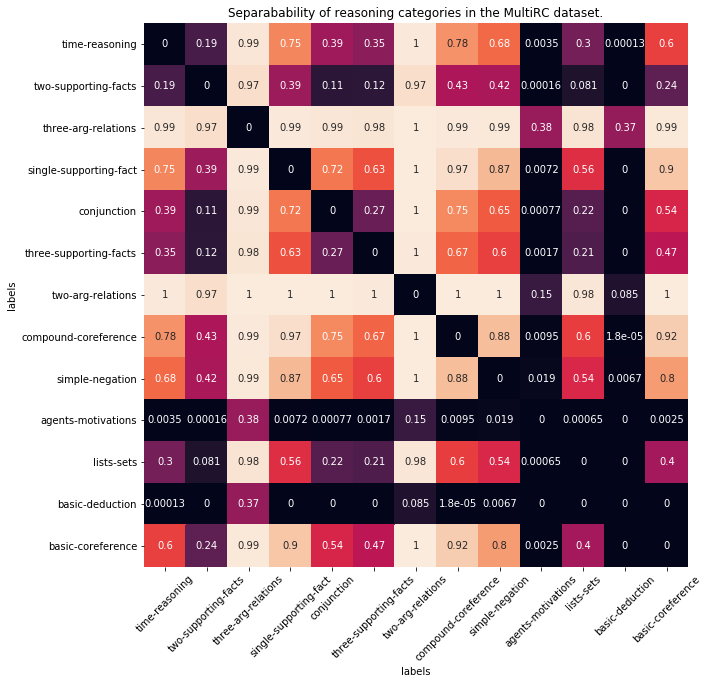

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(separation_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111_list, rotation=45)
sss.set_yticklabels(unique_types111_list, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the MultiRC dataset.')
plt.show()

In [15]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in separation_table]))
print(unique_types111_list)

0.0	0.1882038094503885	0.9850610221280761	0.7476462986893114	0.39198520929791575	0.3520747139951779	0.9960191658380669	0.7766025232572957	0.6849961902922207	0.003513410724957893	0.29980071260341806	0.0001267925293841687	0.6014831754687835
0.1882038094503885	0.0	0.9680987375994575	0.38961272537985564	0.11441484493329984	0.11809627006701366	0.967678360268033	0.42703234110695576	0.41931800561045407	0.00015859170565379432	0.08141076242534367	0.0	0.24463512841006768
0.9850610221280761	0.9680987375994575	0.0	0.992227583042505	0.9851070622434063	0.9826696276685694	0.9999983427108279	0.9933193516576619	0.9893057107620332	0.38253167164486557	0.9770649689846556	0.37468804930448557	0.9889478948271461
0.7476462986893114	0.38961272537985564	0.992227583042505	0.0	0.7178254319325575	0.6349299993192803	0.9999808137793768	0.9679860678119154	0.8683345787744207	0.00723017768864249	0.561447218761848	0.0	0.9040295181383114
0.39198520929791575	0.11441484493329984	0.9851070622434063	0.7178254319325575	0.0	0.

[[0.00000000e+00 3.67200243e-03 3.74814842e-01 1.07435884e-02
  4.28234575e-03 5.21000629e-03 8.48147274e-02 1.44713516e-04
  6.83857523e-03 3.51341072e-03 4.16194920e-03 1.26792529e-04
  5.97192332e-03]
 [3.67200243e-03 0.00000000e+00 3.78486844e-01 7.38876939e-03
  9.27526731e-04 1.85518727e-03 8.84867298e-02 3.81671595e-03
  1.05105777e-02 1.58591706e-04 8.07130178e-04 3.79879496e-03
  2.61710431e-03]
 [3.74814842e-01 3.78486844e-01 0.00000000e+00 3.85558430e-01
  3.79097188e-01 3.80024848e-01 4.59375984e-01 3.74705970e-01
  3.81399832e-01 3.78328253e-01 3.78976791e-01 3.74688049e-01
  3.80786765e-01]
 [1.07435884e-02 7.38876939e-03 3.85558430e-01 0.00000000e+00
  7.99911271e-03 8.92677326e-03 9.55583158e-02 1.08883019e-02
  1.75821636e-02 7.23017769e-03 7.87871616e-03 1.08703809e-02
  9.68869029e-03]
 [4.28234575e-03 9.27526731e-04 3.79097188e-01 7.99911271e-03
  0.00000000e+00 2.46553059e-03 8.90970731e-02 4.42705927e-03
  1.11209210e-02 7.68935025e-04 1.41747350e-03 4.40913828e-0

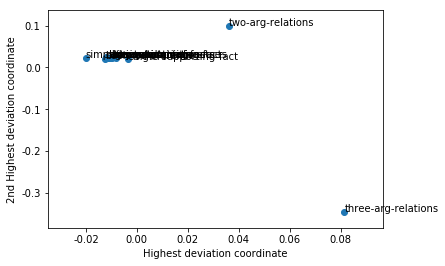

In [16]:
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
# distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(separation_table)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()